In [1]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

In [2]:
PATHS = {
    "prc": r"/Users/hester/Desktop/data/prc_binary.tif",
    "slo": r"/Users/hester/Desktop/data/slo_binary.tif",
    "res": r"/Users/hester/Desktop/data/res_binary.tif",
    "air": r"/Users/hester/Desktop/data/air_binary.tif",
}

OUT_FINAL = r"/Users/hester/Desktop/data/final_suitability.tif"

In [3]:
WORLD_SHP = r"/Users/hester/Desktop/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"

In [4]:
template_key = "prc"
with rasterio.open(PATHS[template_key]) as tpl:
    tpl_meta = tpl.meta.copy()
    tpl_crs = tpl.crs
    tpl_transform = tpl.transform
    tpl_h, tpl_w = tpl.height, tpl.width
    tpl_nodata = tpl.nodata if tpl.nodata is not None else 255

def read_align_to_template(path):
    with rasterio.open(path) as src:
        src_arr = src.read(1)
        src_nodata = src.nodata if src.nodata is not None else 255

        dst = np.full((tpl_h, tpl_w), tpl_nodata, dtype=np.uint8)

        reproject(
            source=src_arr,
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            src_nodata=src_nodata,
            dst_transform=tpl_transform,
            dst_crs=tpl_crs,
            dst_nodata=tpl_nodata,
            resampling=Resampling.nearest 
        )
    return dst

arrs = {k: read_align_to_template(p) for k, p in PATHS.items()}

In [6]:
NODATA = tpl_nodata

stack = np.stack([arrs["prc"], arrs["slo"], arrs["res"], arrs["air"]], axis=0)

any_nodata = np.any(stack == NODATA, axis=0)
any_zero   = np.any(stack == 0, axis=0)
all_one    = np.all(stack == 1, axis=0)

final = np.full((tpl_h, tpl_w), NODATA, dtype=np.uint8)
final[~any_nodata & any_zero] = 0
final[~any_nodata & all_one]  = 1

In [7]:
out_meta = tpl_meta.copy()
out_meta.update(
    dtype="uint8",
    count=1,
    nodata=NODATA,
    compress="lzw"
)

with rasterio.open(OUT_FINAL, "w", **out_meta) as dst:
    dst.write(final, 1)

print("Saved final:", OUT_FINAL)

Saved final: /Users/hester/Desktop/data/final_suitability.tif


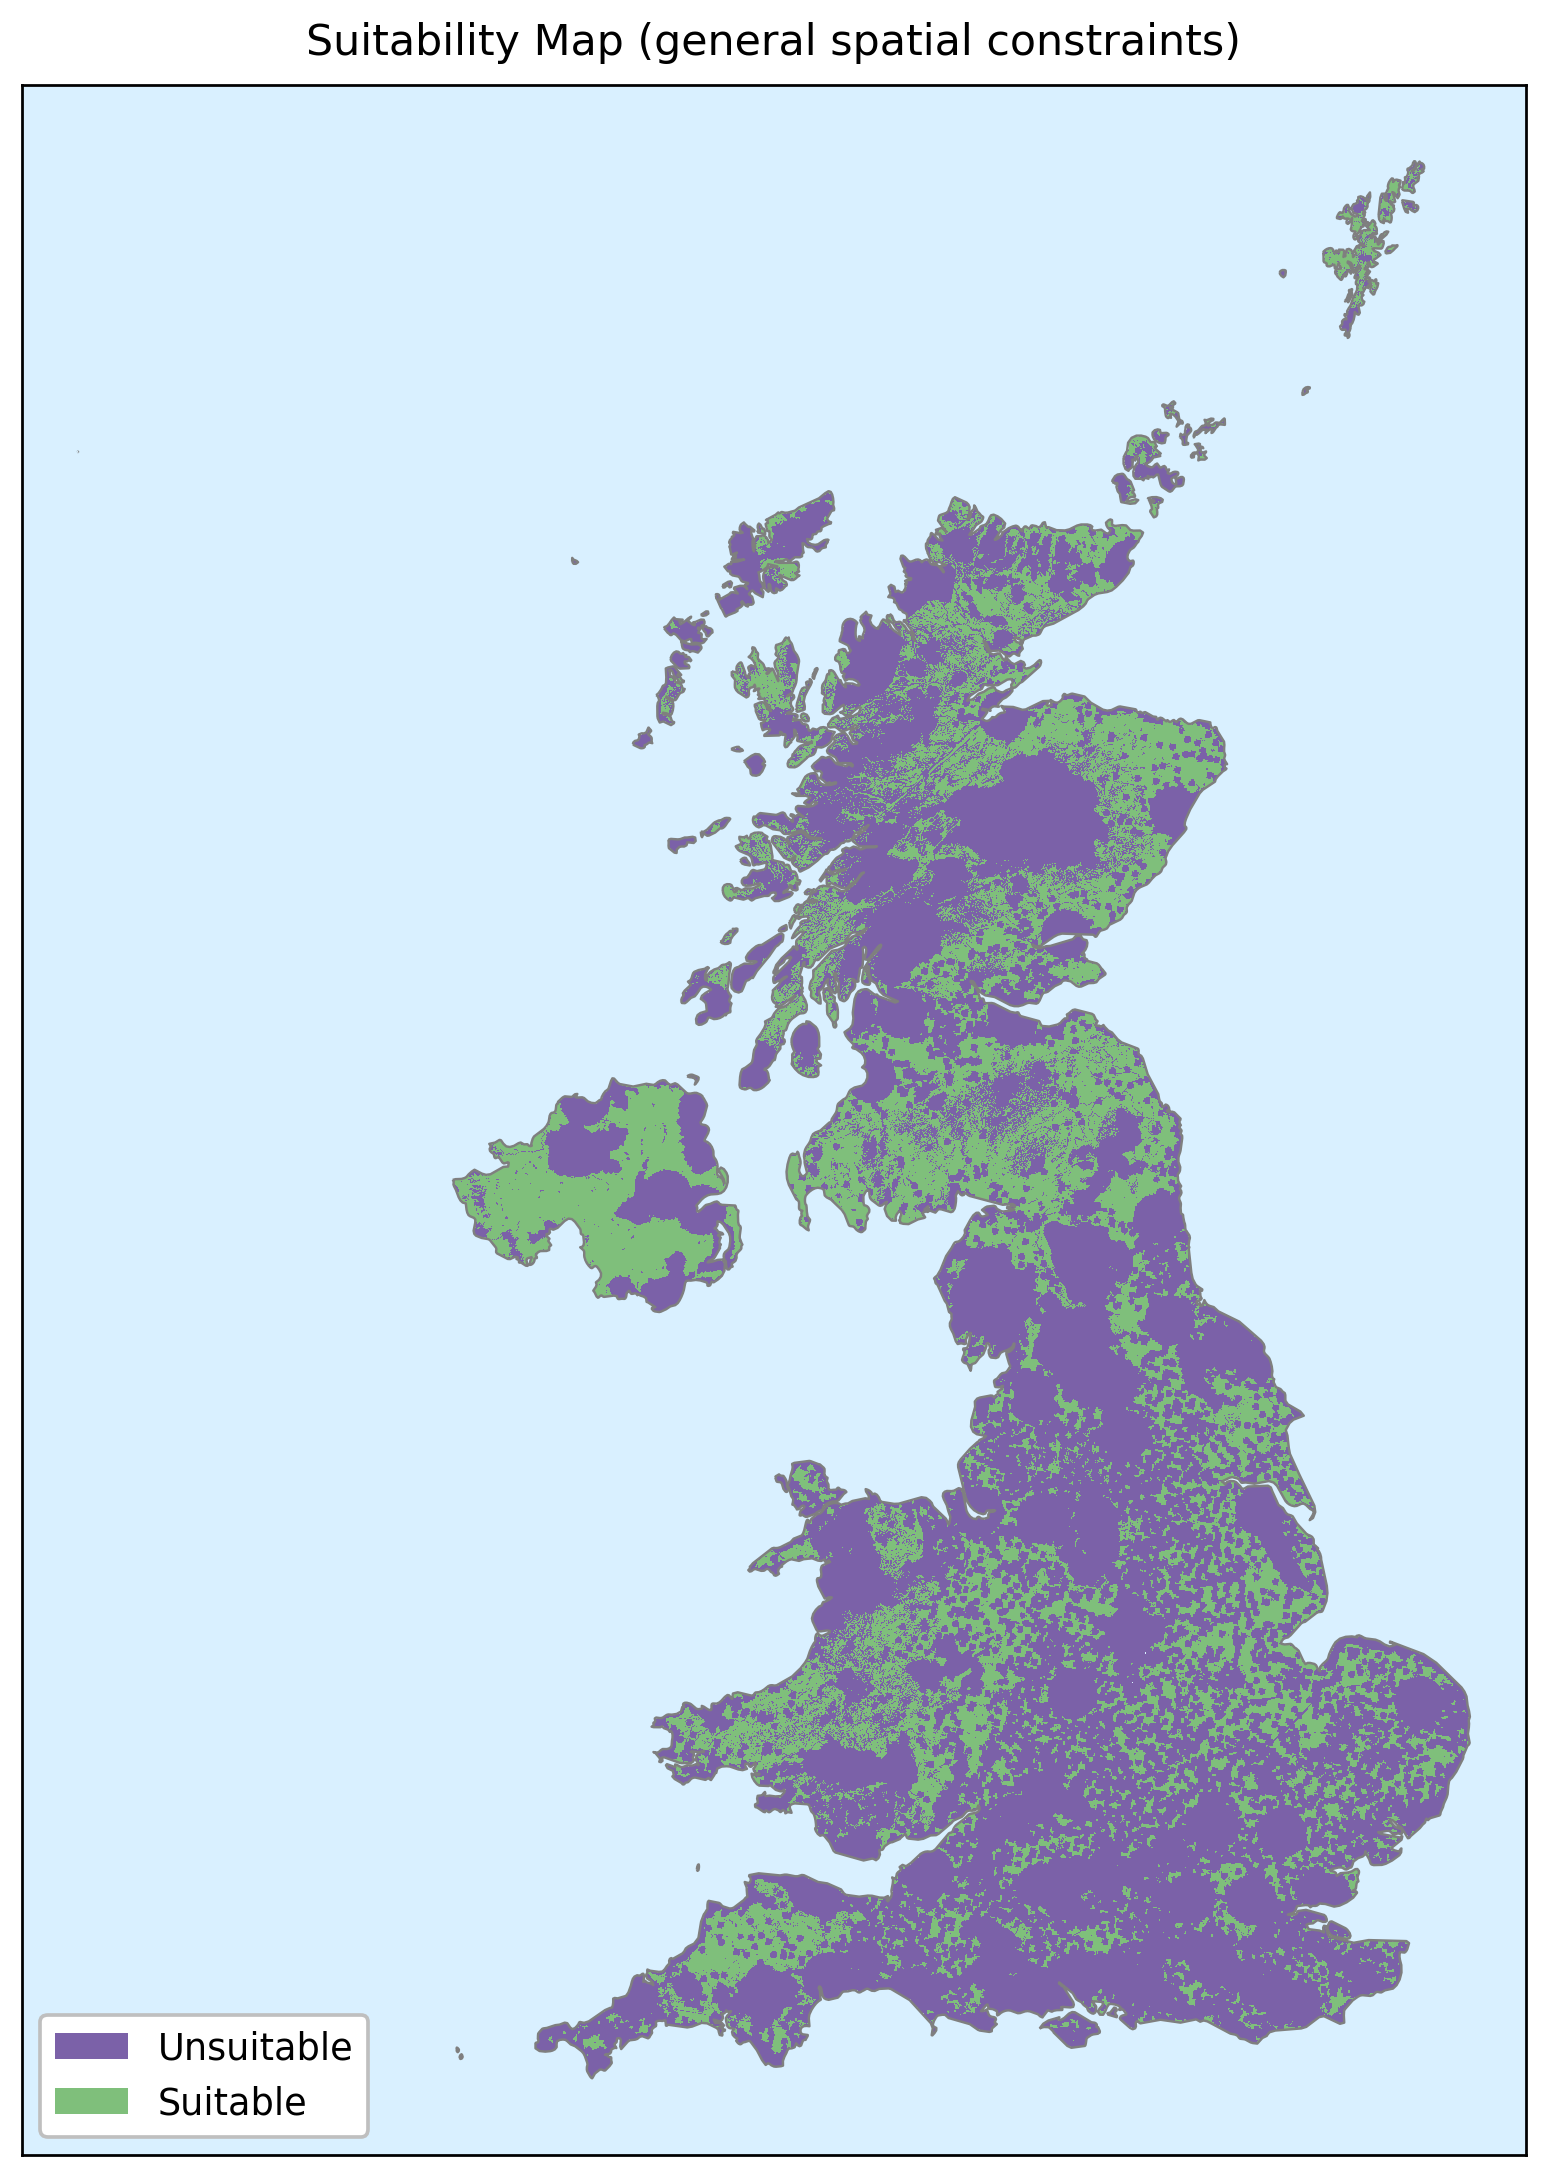

In [8]:
SEA_COLOR = "#d9f0ff"
cmap = ListedColormap(["#7b61a8", "#7fbf7b"])  
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)
cmap.set_bad((0,0,0,0))

plot_arr = final.astype("float32")
plot_arr[plot_arr == NODATA] = np.nan

left, top = tpl_transform * (0, 0)
right, bottom = tpl_transform * (tpl_w, tpl_h)
extent = (left, right, bottom, top)

fig, ax = plt.subplots(1, 1, figsize=(8, 10), dpi=220)
ax.set_facecolor(SEA_COLOR)

ax.imshow(
    plot_arr,
    extent=extent,
    origin="upper",
    interpolation="nearest",
    cmap=cmap,
    norm=norm,
    zorder=1
)

try:
    world = gpd.read_file(WORLD_SHP)
    if "ADM0_A3" in world.columns:
        uk = world[world["ADM0_A3"].astype(str).str.upper() == "GBR"].dissolve()
    elif "ISO_A3" in world.columns:
        uk = world[world["ISO_A3"].astype(str).str.upper() == "GBR"].dissolve()
    else:
        uk = world[world["ADMIN"].astype(str).str.contains("United Kingdom", case=False, na=False)].dissolve()

    uk = uk.to_crs(tpl_crs)
    uk.boundary.plot(ax=ax, edgecolor="#7f7f7f", linewidth=0.8, zorder=3)

    minx, miny, maxx, maxy = uk.total_bounds
    dx, dy = (maxx - minx), (maxy - miny)
    padx, pady = dx * 0.04, dy * 0.04
    ax.set_xlim(minx - padx, maxx + padx)
    ax.set_ylim(miny - pady, maxy + pady)
except Exception as e:
    print("UK boundary skipped:", e)

ax.set_aspect("equal", adjustable="box")
ax.set_title("Suitability Map (general spatial constraints)", fontsize=14, pad=10)

legend_elements = [
    Patch(facecolor="#7b61a8", edgecolor="none", label="Unsuitable"),
    Patch(facecolor="#7fbf7b", edgecolor="none", label="Suitable")
]
leg = ax.legend(
    handles=legend_elements,
    loc="lower left",
    fontsize=12
)
leg.get_frame().set_edgecolor("#bfbfbf")
leg.get_frame().set_linewidth(1.2)
leg.get_frame().set_alpha(1.0)

ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.show()
fig.savefig("Suitability Map (general spatial constraints).png", dpi=300, bbox_inches="tight")